A very rough re-implementation in Julia of the simulation contained in https://github.com/lewis500/macro/tree/gh-pages

In [1]:
using Pkg
Pkg.add("Plots")
using Plots

In [ ]:
mutable struct economyState
    # To store states
    y_history::Vector
    i_history::Vector
    π_history::Vector
    π_e_history::Vector
    r_history::Vector
    u_history::Vector
    y::Float16
    i::Float16
    π::Float16
    π_e::Float16
    r::Float16
    u::Float16

    function economyState(dummy)
        # Starting variables
        new(
            [], # history empty
            [], # history empty
            [], # history empty
            [], # history empty
            [], # history empty
            [], # history empty
            1.0, # y output level
            0.04, # i nominal interest rate
            0.02, # π inflation
            0.02, # π_e inflation expectation
            0.02, # r real interest rate (CHANGE TO FORMULA?)
            0.045 # u unemployment rate
        )
    end
end

In [ ]:
# Fixed values

# parameters
y_bar = 1.0 # non-inflationary output level
r_bar = 0.02 # non-inflationary real interest rate
u_bar = 0.045 # non-inflationary unemployment rate

# sigmas (control rates of change)
σπ = 2.15
σπ_e = 1.3
σy = 1.2
σu = 2

In [ ]:
# TO DO: re-write later so that it takes interest rate decisions as input
# right now, it'll just create simulations stochastically
timeElapse(c::economyState, a::Float64)
function 
    push!(c.y_history, c.y)
    push!(c.i_history, c.i)
    push!(c.π_history, c.π)
    push!(c.π_e_history, c.π_e)
    push!(c.r_history, c.r)
    push!(c.u_history, c.u)

    c.i = ci. + a # new line

    dt = 0.1 # some arbitary measure of time elapsing
    ϵ = rand() * 0.003 
    flip = rand() < 0.5 ? -1 : 1
    η = rand() < 0.25 ? rand() * 0.015 * flip : 0
    flip = rand() < 0.5 ? -1 : 1
    demandShock = rand() < 0.04 ? rand() * 0.04 * flip : 0
    c.r = c.i - c.π_e
    y_dot = - (c.r - r_bar) / σy + η + demandShock
    c.y += y_dot * dt
    c.y = min(c.y, y_bar + (u_bar * σu))
    c.π = c.π_e + (c.y - y_bar) / σπ
    π_e_dot = (c.π - c.π_e) / σπ_e + ϵ
    c.π_e += dt * π_e_dot
    u_dot = -y_dot / σu
    c.u += u_dot * dt
    c.u = max(c.u, 0) # unemployment rate can't be less than 0
    return c

end

In [ ]:
cbsimulator = MDP {
    gen = function (c::economyState, a::Float64)
        push!(c.y_history, c.y)
    push!(c.i_history, c.i)
    push!(c.π_history, c.π)
    push!(c.π_e_history, c.π_e)
    push!(c.r_history, c.r)
    push!(c.u_history, c.u)

    c.i = ci. + a # new line

    dt = 0.1 # some arbitary measure of time elapsing
    ϵ = rand() * 0.003 
    flip = rand() < 0.5 ? -1 : 1
    η = rand() < 0.25 ? rand() * 0.015 * flip : 0
    flip = rand() < 0.5 ? -1 : 1
    demandShock = rand() < 0.04 ? rand() * 0.04 * flip : 0
    c.r = c.i - c.π_e
    y_dot = - (c.r - r_bar) / σy + η + demandShock
    c.y += y_dot * dt
    c.y = min(c.y, y_bar + (u_bar * σu))
    c.π = c.π_e + (c.y - y_bar) / σπ
    π_e_dot = (c.π - c.π_e) / σπ_e + ϵ
    c.π_e += dt * π_e_dot
    u_dot = -y_dot / σu
    c.u += u_dot * dt
    c.u = max(c.u, 0) # unemployment rate can't be less than 0
    r= (c.π == 0.02 ? 100.0 : -1.0) # need to put reward function in here now as it's Gen
    return (c, r) 

    actions = [-0.5, 0., 0.5],
    discount = 0.95,
}


Running some simulations and showing charts just to check that the above code runs as expected and produces a variety of inflationary and deflationary scenarios.

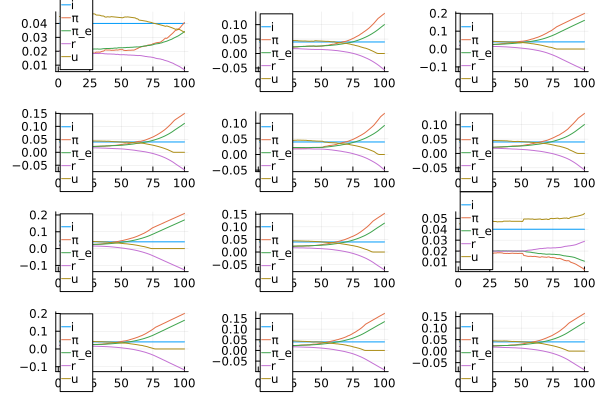

In [50]:
all_chart_data = Plots.Plot{Plots.GRBackend}[]
dt_max = 100
x_axis = collect(1:dt_max)
numSimulations = 12
labelVec = ["i" "π" "π_e" "r" "u"]
for x = 1:numSimulations
    chart_data = []
    sim = economyState("dummy")
    for y = 1:dt_max
        # println(sim.π)
        timeElapse(sim)
    end
    push!(chart_data, sim.i_history)
    push!(chart_data, sim.π_history)
    push!(chart_data, sim.π_e_history)
    push!(chart_data, sim.r_history)
    push!(chart_data, sim.u_history)
    push!(all_chart_data, plot(x_axis, chart_data, label=labelVec))
    
end
plot(all_chart_data..., layout=(4, 3)) # note the splat


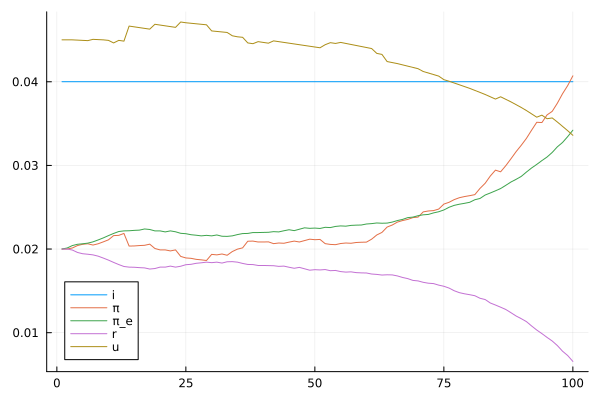

In [51]:
plot1 = all_chart_data[1]
plot(plot1)